In [ ]:
import numpy as np
import cvxpy as cp 
from matplotlib import pyplot as plt
from scipy.linalg import solve_discrete_are
%config InlineBackend.figure_formats = ['svg'] 

# Session 2: Linear MPC
## Assignment 2.4

In [40]:
def build_mpc(N: int):
    Ts = 0.3
    A = np.array([[1, Ts], [0, 1]])
    B = np.array([[0], [Ts]])
    Q = np.diag([10,1])
    R = np.diag([0.01])

    ns = A.shape[0]

    x0 = cp.Parameter((ns,1), "x_init")
    x = [cp.Variable((ns,1), f"x_{i}") for i in range(N+1)]   # 0 to N   states 
    u = [cp.Variable((1,1), f"u_{i}") for i in range(N)]      # 0 to N-1 inputs

    # Start building cost 
    cost = cp.quad_form(x[N], Q)    # Terminal Cost 
    for k in range(N):
        cost += cp.quad_form(x[k], Q) + cp.quad_form(u[k], R)

    # Start building constraints
    # Inequality...
    umax = 10
    umin = -5
    vmax = 25 
    pmax = 1
    xmax = np.array([[pmax],[vmax]])
    constraints =  [uk >= umin for uk in u]
    constraints += [uk <= umax for uk in u]
    constraints += [xk <= xmax for xk in x]

    # equality ...
    constraints += [x[0] == x0 ]
    for k in range(N):
        constraints += [x[k+1] == A @ x[k] + B @ u[k]]

    # build solver 
    solver = cp.Problem(cp.Minimize(cost), constraints)

    return solver 

def check_mpc_feasibility(mpc: cp.Problem, x0: np.ndarray):
    # set parameter value to x0 
    mpc.param_dict["x_init"].value = x0.reshape(-1,1)

    # solve the problem
    cost = mpc.solve()

    if mpc.status == cp.INFEASIBLE:
        return False
    else:
        return True 


def find_feasible_states(N: int, p_vals, v_vals):
    mpc = build_mpc(N)
    feasibile_states = []

    for p in p_vals:
        for v in v_vals:
            x = np.array([p, v])
            # print(f"Checking MPC feasibility for ({p:.2f}, {v:.2f}):\t", end="")
            if check_mpc_feasibility(mpc, x):
                # print("FEASIBLE")
                feasibile_states.append(x)
            else:
                # print("INFEASIBLE")
                pass
    return np.array(feasibile_states)



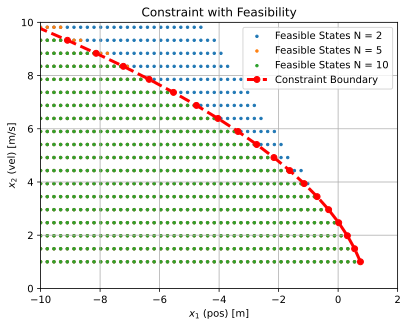

In [44]:
pmax = 1.0
Ts = 0.3
umin = -5
Ngrid = 50
p_vals = np.linspace(-10, 1, Ngrid)
v_vals = np.linspace(1, 25, Ngrid)
p_boundary = pmax - 0.5*v_vals*Ts + 0.5*v_vals**2 / umin

for N in [2,5,10]:
    feasibile_states = find_feasible_states(N,p_vals,v_vals)
    plt.scatter(feasibile_states[:,0], feasibile_states[:,1], s=6, label=f"Feasible States N = {N}")

plt.plot(p_boundary, v_vals, 'ro--', linewidth=3, label="Constraint Boundary")
plt.xlim([-10, 2])
plt.ylim([0, 10])
plt.grid(True)
plt.xlabel(r"$x_1$ (pos) [m]")
plt.ylabel(r"$x_2$ (vel) [m/s]")
plt.title("Constraint with Feasibility")
plt.legend()
# plt.savefig("figs/2.4_feasibility.pdf")